In [1]:
%run /eos/project/l/liu/Toolbox/myToolbox.py

from cpymad.madx import Madx
import requests
from progressbar import ProgressBar
import itertools

%config InlineBackend.figure_format = 'retina'
plt.rcParams["mathtext.fontset"] = "cm"

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.


/eos/project/l/liu/Toolbox/myToolbox.py:24: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


Your platform is Linux-3.10.0-1062.1.2.el7.x86_64-x86_64-with-centos-7.6.1810-Core
Your folder is /eos/home-a/ahuschau/Simulations/PS/MAD-X/zero_dispersion_optics/SC_simulations
Your IP is 172.17.0.33
2019-11-15 16:48:25


In [2]:
def initialize_madx(stdout):
    # setup of MAD-X environment
    #-------------------------------------------------------------------------------------

    if stdout == True:
        madx = Madx()
    else:
        madx = Madx(stdout = stdout)
        
    madx.input('BEAM, PARTICLE=PROTON, PC = 2.79')
    madx.input('BRHO := BEAM->PC * 3.3356;')
    betarel = madx.eval('beam->beta')

    # call sequence of main units
    MU_sequence = requests.get('https://gitlab.cern.ch/acc-models/acc-models-ps/raw/master/ps_mu.seq')
    madx.input(MU_sequence.content)
    # call sequence of straight section elements
    SS_sequence = requests.get('https://gitlab.cern.ch/acc-models/acc-models-ps/raw/master/ps_ss.seq')
    madx.input(SS_sequence.content)
    # call general strength file
    PS_strength = requests.get('https://gitlab.cern.ch/acc-models/acc-models-ps/raw/master/ps.str')
    madx.input(PS_strength.content)
    # call configuration strength file
    strength = requests.get('https://gitlab.cern.ch/acc-models/acc-models-ps/raw/master/scenarios/lhc_proton/1_flat_bottom/ps_fb_lhc.str')
    madx.input(strength.content)

    # twiss for LHC FB configuration - operational working point
    #-------------------------------------------------------------------------------------

    madx.input('use, sequence = PS;')
    madx.input('twiss')
    op = madx.table['twiss'].copy()

    # for type_ in ['F', 'D']:
    #     for i in locations_op[type_]:
    #         madx.input('KQ' + type_ + i + ' :=  K' + type_)

    # # perform tune matching
    # match = '''use, sequence=PS;
    #            MATCH;
    #                 GLOBAL, Q1 = 6.21, Q2 = 6.245;
    #                 VARY, NAME = kf;
    #                 VARY, NAME = kd;
    #                 LMDIF, CALLS=3000, TOLERANCE = 10E-21;
    #            ENDMATCH;
    #         '''
    
    return (madx, op)

def quad_selection(locations, num_of_quads, target, quads_around_SS, twiss):
    '''Select num_of_quads closest to SS specified by quads_around_SS to reduce the ispersion to zero around the target. 
       num_of_quads and quads_around_SS should be integers and the former an even number. '''
    
    # calibration coefficientfrom EDMS371500
    CC = {'N': 0.03537/6./madx.eval('BRHO')/0.12 ,
          'W': 0.02599/6./madx.eval('BRHO')/0.12}
    
    # sort all available quadrupole locations to select num_of_quads from them
    quads = np.empty(0)
    for k in locations_op.keys():
        quads = np.append(quads, locations_op[k])
    quads = np.sort(quads) 

    selection_1 = quads[quads.astype(float) < quads_around_SS][-num_of_quads/2:]
    selection_2 = quads[quads.astype(float) > quads_around_SS][0:num_of_quads/2]

    if len(selection_1) < num_of_quads/2:
        selection_1 = np.append(selection_1, quads[-(num_of_quads/2 - len(selection_1)):])

    if len(selection_2) < num_of_quads/2:
        selection_2 = np.append(selection_2, quads[:(num_of_quads/2 - len(selection_1))])
    
    selection = np.append(selection_1, selection_2)

    vary_cmd = ''
    names = []
    for loc in selection:
        if (loc in locations['FN']):
            lim = 20. * CC['N']
            vary_cmd += 'VARY, NAME = KQFN' + loc + ', LOWER = ' + str(-lim) + ', UPPER = ' + str(lim) + ';'
            names += ['KQFN' + loc]
        elif  (loc in locations['FW']):
            lim = 20. * CC['W']
            vary_cmd += 'VARY, NAME = KQFW' + loc + ', LOWER = ' + str(-lim) + ', UPPER = ' + str(lim) + ';'
            names += ['KQFW' + loc]
        elif (loc in locations['DN']):
            lim = 20. * CC['N']
            vary_cmd += 'VARY, NAME = KQDN' + loc + ', LOWER = ' + str(-lim) + ', UPPER = ' + str(lim) + ';'
            names += ['KQDN' + loc]
        elif  (loc in locations['DW']):
            lim = 20. * CC['W']
            vary_cmd += 'VARY, NAME = KQDW' + loc + ', LOWER = ' + str(-lim) + ', UPPER = ' + str(lim) + ';'
            names += ['KQDW' + loc]
            
    # create matching command
    idx = np.where(twiss['name'] == target.lower() + ':1')[0]
    FROM = twiss['name'][idx-3][0][:-2].upper()
    if 'DRIFT' in FROM:
        FROM = twiss['name'][idx-4][0][:-2].upper()
    
    match = '''use, sequence=PS;
               MATCH;
                    CONSTRAINT, SEQUENCE=PS, RANGE={FROM}/{TO}, DX=0.;
                    CONSTRAINT, SEQUENCE=PS, RANGE={FROM}/{TO}, BETX < 50;
                    CONSTRAINT, SEQUENCE=PS, RANGE={FROM}/{TO}, BETY < 50;
                    {VARY}
                    LMDIF, CALLS=3000, TOLERANCE = 10E-6;
               ENDMATCH;
            '''.format(FROM = FROM, TO = target, VARY = vary_cmd)
    
    out = {'match': match, 'selection': selection, 'quads': names}
    return out

def beam_envelope(twiss, en, dp, pc, plane = 0):
    
    gamma = myToolbox.P_GeVToGamma(pc)
    betarel = myToolbox.P_GeVToBeta(pc)
    betgamma = betarel * gamma
    eg=en/betgamma;
    
    if plane == 0:
        sigma = np.sqrt(3**2*eg*twiss['betx']+(2*twiss['dx']*betarel*dp)**2);

    if plane == 1:
        sigma = np.sqrt(3**2*eg*twiss['bety']);

    return sigma

In [3]:
# locations of operational quads 
locations_op = {'FN': np.array(['05', '09', '21', '35', '39', '45', '49', '55', '67', '71', '77', '81', '85', '89', '95', '99']),
                'FW': np.array(['17', '27', '31', '59']),
                'DN': np.array(['10', '36', '40', '46', '50', '68', '72', '78', '82', '86', '90', '96', '00']),
                'DW': np.array(['06', '18', '22', '28', '32', '56', '60'])}

In [4]:
gamma = myToolbox.P_GeVToGamma(2.79)
en=1.8*1E-6;
dp=1.5E-3;

result = './PI.BSG48_100_iterations.pkl'
device = pnd.read_pickle(result)
target = result[2:10]

# Zero dispersion at PI.BSG48

## Configuration 1: large beta-beating and zero dispersion

In [5]:
madx, op = initialize_madx(True)
betarel = madx.eval('beam->beta')

out = quad_selection(locations_op, 10, target, 0, op)

madx.input(out['match'])
madx.input('twiss')
twiss = madx.table['twiss'].copy()
qx = np.round(madx.table['summ']['Q1'], 2)[0]
qy = np.round(madx.table['summ']['Q2'], 2)[0]


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.04.02  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2018.10.03               +
  + Execution date: 2019.11.15 16:48:45      +
  ++++++++++++++++++++++++++++++++++++++++++++
++++++ warning: skipped, command or element unknown: pr.qsk03
++++++ warning: skipped, command or element unknown: pr.qsk37
++++++ warning: skipped, command or element unknown: pr.qsk53
++++++ warning: skipped, command or element unknown: pr.qsk69
++++++ warning: skipped, command or element unknown: pr.qsk79
++++++ warning: skipped, command or element unknown: pr.qsk83
++++++ warning: skipped, command or element unknown: pr.qsk87
++++++ warning: skipped, command or element unknown: pr.qsk91
++++++ warning: skipped, command or element unknown: pr.qsk97
++++++ warning: skipped, command or element unknown: pr.qsk04
++++++ warning: skipped, command or element unknown: pr.qsk08
++++++ warning: skipped, command or

In [6]:
print('\nMatching results:')
for q in out['quads']:
    print(q + '= ' + str(madx.eval(q)) + ';')


Matching results:
KQFN89= -0.0681172535243;
KQDN90= -0.0628955655243;
KQFN95= 0.094982831884;
KQDN96= 0.075953543199;
KQFN99= 0.0313663626557;
KQFN05= -0.0672773852644;
KQDW06= -0.0546827792559;
KQFN09= -0.105407643798;
KQDN10= 0.0500132847576;
KQFW17= 0.0770376522923;


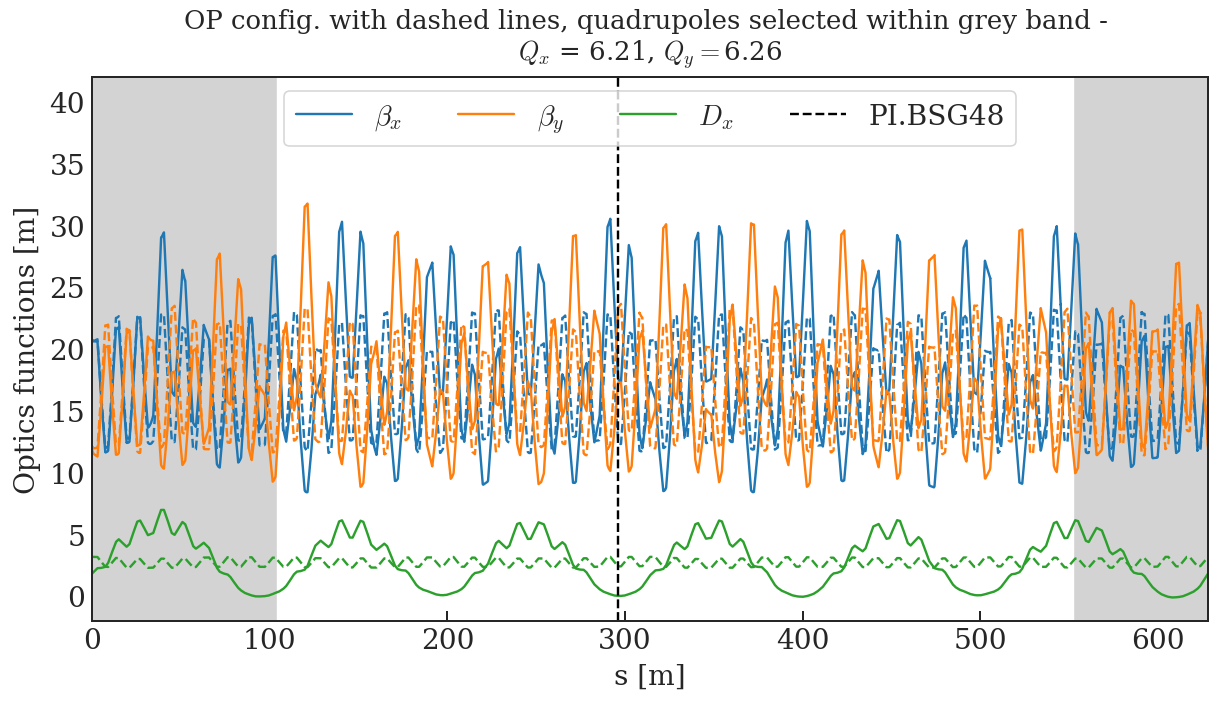

In [7]:
for i in xrange(1):
    f, ax = plt.subplots(1, figsize = (10, 5))

    plt.axvspan(twiss['s'][0], twiss['s'][np.where(twiss['name'] == 'ps' + out['selection'][-1] + '$end:1')[0]], color = 'lightgrey')
    plt.axvspan(twiss['s'][np.where(twiss['name'] == 'ps' + out['selection'][0] + '$start:1')[0]], twiss['s'][-1], color = 'lightgrey')
    p1 = plt.plot(twiss['s'], twiss['betx'], label = r'$\beta_x$')
    plt.plot(op['s'], op['betx'], color = p1[0].get_color(), ls = '--')
    p2 = plt.plot(twiss['s'], twiss['bety'], label = r'$\beta_y$')
    plt.plot(op['s'], op['bety'], color = p2[0].get_color(), ls = '--')
    p3 = plt.plot(twiss['s'], twiss['dx']*betarel, label = '$D_x$')
    plt.plot(op['s'], op['dx']*betarel, color = p3[0].get_color(), ls = '--')

    plt.axvline(twiss['s'][twiss['name'] == target.lower() + ':1'], ls = '--', color = 'k', label = target)

    plt.xlabel('s [m]')
    plt.ylabel('Optics functions [m]')
    plt.legend(ncol = 4, loc = 'upper center')
    plt.ylim(-2, 42)
    plt.xlim(0, 2*np.pi*100)
    plt.title('OP config. with dashed lines, quadrupoles selected within grey band - \n$Q_x$ = ' + str(qx) + ', $Q_y = $' + str(qy), fontsize = 13)
    if i == 1:
        plt.ylim(-0.1, 1)
    plt.savefig('Zero_dispersion_conf_1.pdf')

## Configuration 2: smaller beta-beating and almost zero dispersion

In [8]:
madx, op = initialize_madx(True)
betarel = madx.eval('beam->beta')

out = quad_selection(locations_op, 10, target, 37, op)

madx.input(out['match'])
madx.input('twiss')
twiss = madx.table['twiss'].copy()
qx = np.round(madx.table['summ']['Q1'], 2)[0]
qy = np.round(madx.table['summ']['Q2'], 2)[0]


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.04.02  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2018.10.03               +
  + Execution date: 2019.11.15 16:49:02      +
  ++++++++++++++++++++++++++++++++++++++++++++
++++++ warning: skipped, command or element unknown: pr.qsk03
++++++ warning: skipped, command or element unknown: pr.qsk37
++++++ warning: skipped, command or element unknown: pr.qsk53
++++++ warning: skipped, command or element unknown: pr.qsk69
++++++ warning: skipped, command or element unknown: pr.qsk79
++++++ warning: skipped, command or element unknown: pr.qsk83
++++++ warning: skipped, command or element unknown: pr.qsk87
++++++ warning: skipped, command or element unknown: pr.qsk91
++++++ warning: skipped, command or element unknown: pr.qsk97
++++++ warning: skipped, command or element unknown: pr.qsk04
++++++ warning: skipped, command or element unknown: pr.qsk08
++++++ warning: skipped, command or

In [9]:
print('\nMatching results:')
for q in out['quads']:
    print(q + '= ' + str(madx.eval(q)) + ';')


Matching results:
KQDW28= 0.0757297180705;
KQFW31= 0.0775756834198;
KQDW32= 0.0775756834198;
KQFN35= -0.0594659200772;
KQDN36= -0.0789023831646;
KQFN39= -0.0982846394342;
KQDN40= -0.105573371396;
KQFN45= 0.0305545585327;
KQDN46= 0.105573371396;
KQFN49= 0.0353049579112;


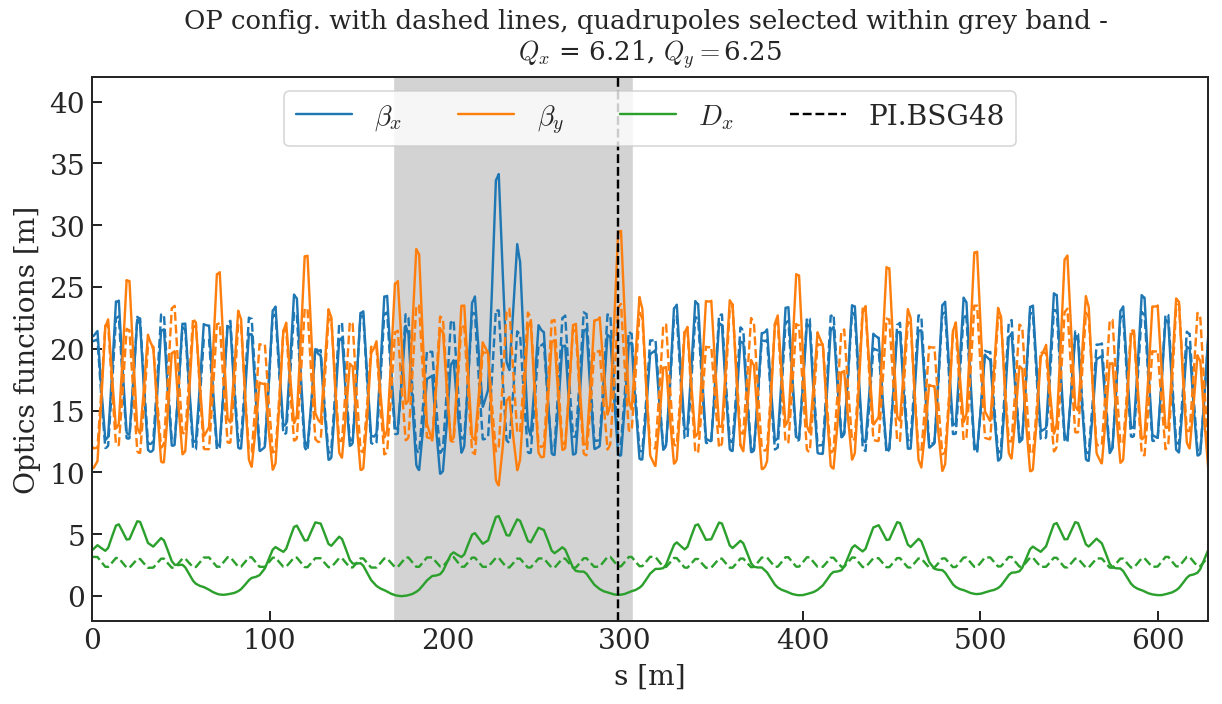

In [10]:
for i in xrange(1):
    f, ax = plt.subplots(1, figsize = (10, 5))

    plt.axvspan(twiss['s'][np.where(twiss['name'] == 'ps' + out['selection'][0] + '$start:1')[0]], twiss['s'][np.where(twiss['name'] == 'ps' + out['selection'][-1] + '$end:1')[0]], color = 'lightgrey')
    p1 = plt.plot(twiss['s'], twiss['betx'], label = r'$\beta_x$')
    plt.plot(op['s'], op['betx'], color = p1[0].get_color(), ls = '--')
    p2 = plt.plot(twiss['s'], twiss['bety'], label = r'$\beta_y$')
    plt.plot(op['s'], op['bety'], color = p2[0].get_color(), ls = '--')
    p3 = plt.plot(twiss['s'], twiss['dx']*betarel, label = '$D_x$')
    plt.plot(op['s'], op['dx']*betarel, color = p3[0].get_color(), ls = '--')

    plt.axvline(twiss['s'][twiss['name'] == target.lower() + ':1'], ls = '--', color = 'k', label = target)

    plt.xlabel('s [m]')
    plt.ylabel('Optics functions [m]')
    plt.legend(ncol = 4, loc = 'upper center')
    plt.ylim(-2, 42)
    plt.xlim(0, 2*np.pi*100)
    plt.title('OP config. with dashed lines, quadrupoles selected within grey band - \n$Q_x$ = ' + str(qx) + ', $Q_y = $' + str(qy), fontsize = 13)
    if i == 1:
        plt.ylim(-0.1, 1)
    plt.savefig('Zero_dispersion_conf_2.pdf')